# Stochastic Models and Simulations of Phototaxis
[Link](https://www.researchgate.net/profile/Devaki-Bhaya/publication/265289716_Stochastic_Models_and_Simulations_of_Phototaxis/links/5535445a0cf268fd0015d694/Stochastic-Models-and-Simulations-of-Phototaxis.pdf)

In [804]:
using Random, LinearAlgebra, Plots

# Functions

In [660]:
"""
Convert polar coordinates to cartesian
"""
polar2cart(r, θ) = r .* [cos(θ) sin(θ)]

"""
Sample N points from a circle of radius R
https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409

"""
function sampleCircle(N, R)
    # Sample radii
    # PDF = 2x; CDF = x²; CDF⁻¹ = √x
    radii = R * sqrt.(rand(N))
    
    # Sample angles
    # theta = 0 - 2π
    thetas = rand(N) * 2π

    # points
    X = polar2cart.(radii, thetas)
    return X
end


"""Compute all pairwise distances between each point in X
Store in condensed distance matrix form (flattening of upper triangle)

# Inputs
| X: n (observations) x m (dimensions) matrix 
| f(a, b): function to compute distances between a, b
"""
function pairwiseDistance(X, f)
    n = size(X)[1]
    dists = zeros(n, n)
    for i in 1:n
        a = X[i]
        for j in i:n
            b = X[j]
            # Compute distance
            d = f(a, b)
            # Save
            dists[i, j] = dists[j, i] = d
        end
    end
    return dists
end

"""
Compute Euclidean distance between a and b
"""
euclidDist(a, b) = norm(a - b)

"""
Compute the angle between two points
"""
function angleBetween(a, b)
#     # Compute cos(θ) (clip between -1 and 1 bc of precision)
#     cosθ = clamp((a ⋅ b) / norm(a) / norm(b), -1, 1)
#     θ = acos(cosθ)
    # https://stackoverflow.com/a/35134034/7238814
    return atan(det([vec(a) vec(b)]), a ⋅ b)
end

"""
Sample n points from a PDF, p
"""
function sampleDiscrete(n, p)
    # Compute cdf (Normalize to sum to 1)
    cdf = cumsum(p) / sum(p)
    # Sample
    choices = [searchsortedfirst(cdf, rand()) for _ in 1:n]
end

sampleDiscrete

# Local interactions
At any
given point in time, we assume that every cell may move according to one of the
following three options (shown in Figure 2):
1. a cell may continue to move without changing its previous direction
2.  a cell can stop moving
3. a cell may orient itself. In this case it will moves in the direction of one of its
neighboring cells. The candidate neighboring cells must be within a certain
interaction distance (shown as the dotted circle in Figure 2(c)).

In [941]:
"""
Update step for local interactions model
"""
#TODO: KEEP TRACK OF VELOCITY

function localInteractionsUpdate(dists, η, X, i, D, p)
    # Indices of local interactions
    B = findall(dists .<= D)

    # Number of non-self elements in B
    nB = length(B) - 1
    
    if nB == 0 
        new_X = X
        new_θ = ηs[i]
    else
        # Choose new angle 
        # (with probability a of not switching and a uniform chance of other directions)
        θpdf = [q != i ? ((1 - p.a) / nB) : p.a for q = B]
        θs = η[B]
        new_θ = θs[sampleDiscrete(1, θpdf)[1]]

        # Choose new velocity
        new_v = rand() > p.b

        # Update position
        new_X = X .+ polar2cart(new_v, new_θ)
    end
    # Save
    return new_X, new_θ
    
end

localInteractionsUpdate

In [944]:
"""Parameters"""
N = 100
R = 200
D = 30

"""Initialize"""
# Initialize points
# Random.seed!(123)
X = sampleCircle(N, R)


# Pairwise distances
dists = pairwiseDistance(X, euclidDist)

# Initialize directions
θs = rand(N) * 2pi
# Pairwise angles
η = pairwiseDistance(X, angleBetween)
# Flip sign for opposite directions
η += LowerTriangular(η) * -2
# Add self-direction
η[diagind(η)] = θs

# Parameters
p = (a=.8, b=.5)

(a = 0.8, b = 0.5)

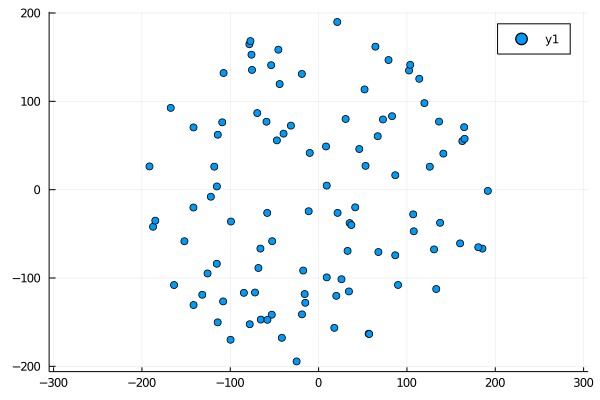

In [942]:
Xmat = vcat(X...)
scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal)

In [945]:
@time begin
    # Run simulation
    tf = 350
    Xs = [X]
    t = 1
    save_ts = [50, 350]
    while t < (tf + 1)
        # Select new X and θ
        X_curr = X
        η_curr = η
        
        X = []
        θs = []
        for i = 1:N
            new_X, new_θ = localInteractionsUpdate(dists[i, :], η_curr[i, :], X_curr[i], i, D, p)
            push!(X, new_X)
            push!(θs, new_θ)
        end
#         X = [localInteractionsUpdate(dists[i, :], ηs[i, :], X[i], i, D, p) for i in 1:N]
        if t in save_ts
            push!(Xs, X)
        end
        if t == tf
            break
        end
        # Recompute pairwise distances
        # Pairwise distances
        dists = pairwiseDistance(X, euclidDist)
        # Pairwise angles
        η = pairwiseDistance(X, angleBetween)
        # Flip sign for opposite directions
        η += LowerTriangular(η) * -2
        # Add self-direction
        η[diagind(η)] = θs
        t += 1
    end
end

  3.414729 seconds (18.75 M allocations: 1.216 GiB, 7.68% gc time)


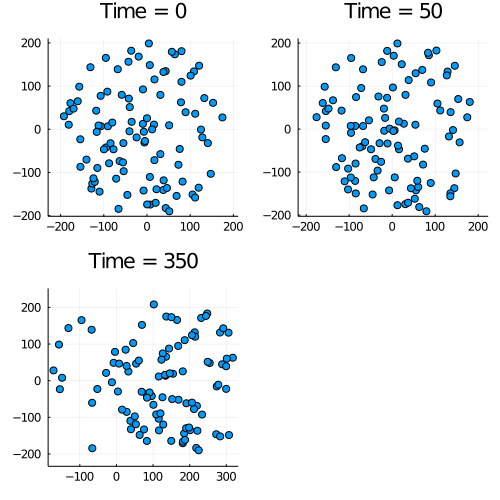

In [946]:
# Visualize
plts = []
for (x, t) in zip(Xs, [0, 50, 350])
    Xmat = vcat(x...)
    plt = scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, legend=false,size=(500, 500))
    title!("Time = $t")
    push!(plts, plt)
end
plot(plts...)

# WHY VEARING TO THE RIGHT?